In [1]:
# Mount Google Drive if using Colab
try:
    from google.colab import drive
    drive.mount('/content/drive')
    USING_COLAB = True
except:
    USING_COLAB = False

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
import time
from datetime import datetime

In [4]:
from concurrent.futures import ThreadPoolExecutor
from nltk.corpus import stopwords
import spacy
import nltk
import string
import threading

In [5]:
if USING_COLAB:
    path_dataset = "/content/drive/My Drive/GTSI/Codigos_proyectos_carrera/data"
    sufix = "colab"
else:
    path_dataset = "./data"
    sufix = "colab"

In [6]:
pd.set_option('display.max_columns', None)

In [7]:
df = pd.read_csv(path_dataset + "/projects_augmented_" + sufix + ".csv")

C:\Users\saraujo\AppData\Local\Temp\ipykernel_47788\2602201521.py:1: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path_dataset + "/projects_augmented_" + sufix + ".csv")


In [8]:
df = df.iloc[:5000]

In [9]:
df.rename(columns={"titulo": "text"}, inplace=True)

In [10]:
df.shape

(5000, 9)

In [11]:
df.tail(10)

,text,FACULTAD,CARRERA,NOMBREPROYEC,counts,URL,ESTADO,gpu_used,batch_id
4990,diseño fabricación y caracterización mecánica ...,Facultad de Ingeniería en Mecánica y Ciencias ...,Mecánica,"Diseño, fabricación y caracterización mecánica...",9.0,0,Activa,NaN,NaN
4991,análisis hidrometeorológico actualizado para e...,Facultad de Ingeniería Marítima y Ciencias del...,Oceanografía,Análisis hidro-meteorológico actualizado para ...,9.0,0,Activa,NaN,NaN
4992,análisis histórico y aplicación de modelos pre...,Facultad de Ciencias Sociales y Humanísticas,Economía,Análisis Histórico y Aplicación de Modelos Pre...,9.0,https://dspace.espol.edu.ec/handle/123456789/6...,Activa,NaN,NaN
4993,estudio y diseño de edificación de propiedad d...,Facultad de Ingeniería en Ciencias de la Tierra,Ingeniería Civil,Estudio y diseño de Edificación de propiedad d...,9.0,0,Activa,NaN,NaN
4994,análisis del consumo energético generado en el...,Facultad de Ingeniería en Ciencias de la Tierra,Minas,Análisis del consumo energético generado en el...,9.0,0,Activa,NaN,NaN
4995,repositorio de patrones visuales basados en la...,"Facultad de Arte, Diseño y Comunicación Audiov...",Diseño Gráfico,Repositorio de patrones visuales basados en la...,9.0,https://dspace.espol.edu.ec/handle/123456789/5...,Activa,NaN,NaN
4996,diseño de un material a base de cemento y ceni...,Facultad de Ingeniería en Ciencias de la Tierra,Ingeniería Civil,Diseño de un material a base de cemento y ceni...,9.0,0,Activa,NaN,NaN
4997,diseño de metodología de cuestionarios para la...,Facultad de Ciencias Sociales y Humanísticas,Turismo,Diseño de metodología de cuestionarios para la...,9.0,0,Activa,NaN,NaN
4998,desarrollo de la cadena de producción de alime...,Facultad de Ingeniería en Mecánica y Ciencias ...,Alimentos,Desarrollo de la cadena de producción de alime...,9.0,https://dspace.espol.edu.ec/handle/123456789/4...,Activa,NaN,NaN
4999,reducir el porcentaje de errores en inventario...,Facultad de Ingeniería en Mecánica y Ciencias ...,Ingeniería Industrial,Reducir el porcentaje de errores en inventario...,9.0,0,Activa,NaN,NaN


In [12]:
df["text"].nunique(), df["NOMBREPROYEC"].nunique(), df["FACULTAD"].nunique(), df["CARRERA"].nunique()

(4924, 4944, 8, 33)

In [13]:
df_carrera_count = df["CARRERA"].value_counts()
df_carrera_count[df_carrera_count == 5000].shape, df["CARRERA"].nunique()

((0,), 33)

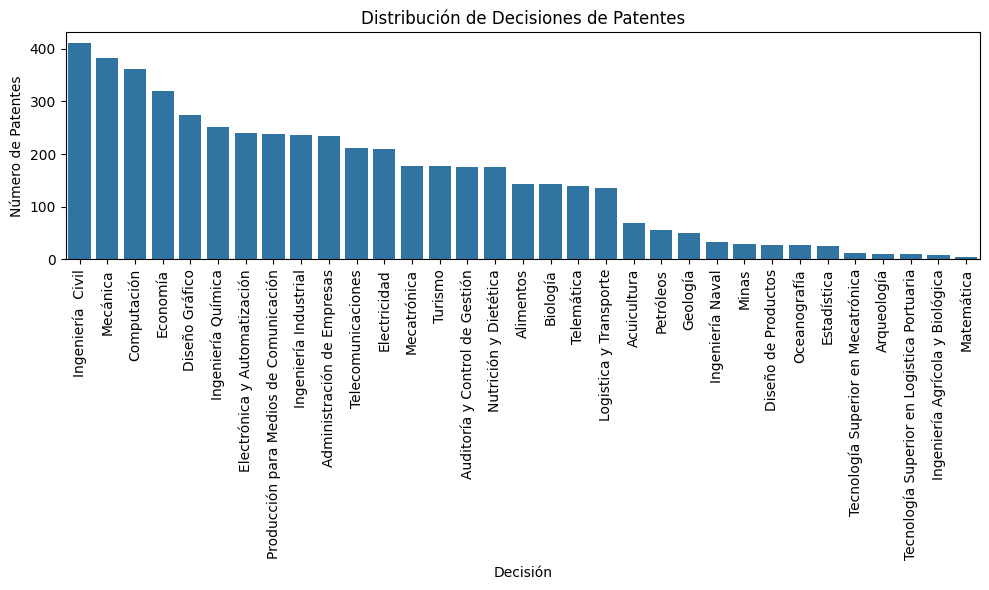

In [14]:
# diagrama de barras de la columna "decision"
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='CARRERA', order=df['CARRERA'].value_counts().index)
plt.title('Distribución de Decisiones de Patentes')
plt.xlabel('Decisión')
plt.ylabel('Número de Patentes')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Lematizacion

In [15]:
# !python -m spacy download es_core_news_lg

In [16]:
nlp = spacy.load("es_core_news_lg")

In [17]:
stopwords_es = set(stopwords.words('spanish'))
stopwords_en = set(stopwords.words('english'))
stop_words = stopwords_es | stopwords_en

In [18]:
# Función de limpieza y lematización
def procesar_texto(texto):
    if pd.isna(texto):
        return ""
    # Unicode, minúsculas, quitar puntuación
    texto = texto.lower().translate(str.maketrans('', '', string.punctuation))
    # Procesar con spaCy
    doc = nlp(texto)
    # Lematizar y quitar stopwords
    tokens = [token.lemma_ for token in doc if token.lemma_ not in stop_words and not token.is_punct and not token.is_space]
    # *************************************** REVISAR *****************************************
    # tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and not token.is_space]
    # *****************************************************************************************

    return " ".join(tokens)

# Unir columnas y procesar
def crear_corpus(row):
    return procesar_texto(str(row['text']))

In [19]:
# OPCIÓN 1: Paralelización con ThreadPoolExecutor (más simple)
def procesar_corpus_paralelo_threads(df, num_threads=3):
    """
    Paraleliza el procesamiento usando ThreadPoolExecutor
    Mejor para I/O bound tasks
    """
    def procesar_batch(batch_df):
        """Procesa un batch de filas"""
        return batch_df.apply(crear_corpus, axis=1)
    
    # Dividir el DataFrame en batches
    batches = np.array_split(df, num_threads)
    
    print(f"Procesando {len(df)} filas en {num_threads} hilos...")
    print(f"Tamaños de batch: {[len(batch) for batch in batches]}")
    
    # Procesar en paralelo
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        results = list(executor.map(procesar_batch, batches))
    
    # Concatenar resultados
    corpus_procesado = pd.concat(results, ignore_index=True)
    return corpus_procesado


# Híbrida - dividir por chunks y usar threads
def procesar_corpus_paralelo_chunks(df, num_threads=3, chunk_size=1000):
    """
    Divide el DataFrame en chunks y procesa cada chunk en paralelo
    Útil para DataFrames muy grandes
    """
    def procesar_chunk(chunk_data):
        chunk_df, chunk_idx = chunk_data
        
        # Obtener información del hilo actual
        thread_id = threading.current_thread().ident
        thread_name = threading.current_thread().name
        start_time = time.time()
        timestamp = datetime.now().strftime("%H:%M:%S.%f")[:-3]
        
        print(f"  [{timestamp}] 🚀 Chunk {chunk_idx:2d} ({len(chunk_df):4d} filas) -> {thread_name} (ID: {thread_id})")

        return chunk_df.apply(crear_corpus, axis=1)
    
    # Dividir en chunks
    chunks = []
    for i in range(0, len(df), chunk_size):
        chunk = df.iloc[i:i+chunk_size]
        chunks.append((chunk, i//chunk_size))
    
    print(f"📊 Procesando {len(df)} filas en {len(chunks)} chunks usando {num_threads} hilos...")
    print(f"📦 Tamaños de chunks: {[len(chunk[0]) for chunk in chunks]}")

    start_total = time.time()
    
    # Procesar chunks en paralelo
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        print(f"\n🔄 Iniciando procesamiento paralelo...")
        results = list(executor.map(procesar_chunk, chunks))
        print(f"\n🎉 Procesados {len(results)} chunks")

    end_total = time.time()
    total_duration = end_total - start_total
    
    print(f"\n🎉 Todos los chunks procesados en {total_duration:.2f}s")

    # Concatenar resultados
    corpus_procesado = pd.concat(results, ignore_index=True)
    print(f"✅ Procesamiento completo. Total de filas procesadas: {len(corpus_procesado)}")
    return corpus_procesado

In [ ]:
# Método Chunks con threads
print("Usando chunks con ThreadPoolExecutor:")
df["CORPUS"] = procesar_corpus_paralelo_chunks(df, num_threads=12, chunk_size=500) # 2 min 59.2s
# df["CORPUS"] = procesar_corpus_paralelo_threads(df, num_threads=12) #, 4 min 28.4s

print("Shape del dataframe: ", df.shape[0])

Usando chunks con ThreadPoolExecutor:
📊 Procesando 5000 filas en 10 chunks usando 12 hilos...
📦 Tamaños de chunks: [500, 500, 500, 500, 500, 500, 500, 500, 500, 500]

🔄 Iniciando procesamiento paralelo...
  [14:20:51.179] 🚀 Chunk  0 ( 500 filas) -> ThreadPoolExecutor-0_0 (ID: 37896)
  [14:20:51.184] 🚀 Chunk  1 ( 500 filas) -> ThreadPoolExecutor-0_1 (ID: 41096)
  [14:20:51.192] 🚀 Chunk  2 ( 500 filas) -> ThreadPoolExecutor-0_2 (ID: 36916)
  [14:20:51.200] 🚀 Chunk  3 ( 500 filas) -> ThreadPoolExecutor-0_3 (ID: 36072)
  [14:20:51.209] 🚀 Chunk  4 ( 500 filas) -> ThreadPoolExecutor-0_4 (ID: 26408)
  [14:20:51.214] 🚀 Chunk  5 ( 500 filas) -> ThreadPoolExecutor-0_5 (ID: 40948)
  [14:20:51.226] 🚀 Chunk  6 ( 500 filas) -> ThreadPoolExecutor-0_6 (ID: 2264)
  [14:20:51.254] 🚀 Chunk  7 ( 500 filas) -> ThreadPoolExecutor-0_7 (ID: 15048)
  [14:20:51.263] 🚀 Chunk  8 ( 500 filas) -> ThreadPoolExecutor-0_8 (ID: 18644)
  [14:20:51.274] 🚀 Chunk  9 ( 500 filas) -> ThreadPoolExecutor-0_9 (ID: 2016)

🎉 Proc

In [21]:
df.head(5)

,text,FACULTAD,CARRERA,NOMBREPROYEC,counts,URL,ESTADO,gpu_used,batch_id,CORPUS
0,preparación de nano celulosa y su utilización ...,Facultad de Ciencias Naturales y Matemáticas,Ingeniería Química,Preparación de nano celulosa y su utilización ...,72.0,0,Activa,NaN,NaN,preparación nano celulós utilización material ...
1,monitoreo no intrusivo de cargas eléctricas en...,Facultad de Ciencias Naturales y Matemáticas,Logistica y Transporte,MONITOREO NO INTRUSIVO DE CARGAS ELÉCTRICAS EN...,71.0,0,Activa,NaN,NaN,monitoreo intrusivo carga eléctrico consumidor...
2,difusión del uso de herramientas tecnológicas ...,"Facultad de Arte, Diseño y Comunicación Audiov...",Diseño Gráfico,Difusión del uso de herramientas tecnológicas ...,62.0,0,Activa,NaN,NaN,difusión uso herramienta tecnológico agricultu...
3,variacion del tiempo de fraguado debido a mixt...,Facultad de Ingeniería en Ciencias de la Tierra,Ingeniería Civil,Variacion del tiempo de fraguado debido a mixt...,56.0,0,Activa,NaN,NaN,variacion tiempo fraguado debido mixtura aditivo
4,tecnologías aplicadas y análisis económico en ...,Facultad de Ciencias Sociales y Humanísticas,Economía,Tecnologías aplicadas y análisis económico en ...,54.0,0,Activa,NaN,NaN,tecnología aplicado análisis económico producc...


In [ ]:
df_copy = df.copy()

In [ ]:
df_copy.to_csv(path_dataset + "/projects_processed_" + sufix + ".csv", index=False)
print(f"Archivo guardado en: {path_dataset}/projects_processed_{sufix}.csv")
print("¡Procesamiento completado y archivo guardado!")

Archivo guardado en: ./data/projects_processed_colab.csv
¡Procesamiento completado y archivo guardado!
